In [5]:
"""
Copyright 2018 Kitware
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding1D
from keras.layers import MaxPooling1D, Lambda
from keras.layers.convolutional import UpSampling2D, Conv1D, Cropping1D
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, concatenate, Add
import keras.backend as K


import keras.utils
from keras.engine.topology import Layer
class Bias(Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(input_shape[-1],),
                                        initializer="zeros",
                                        name='bias',
                                        regularizer=None,
                                        constraint=None)
        super(Bias, self).build(input_shape)
        
    def call(self, inputs):
        outputs = K.bias_add(
                inputs,
                self.bias)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape


keras.layers.Bias = Bias

def partial_convolution(input_, mask, filters, shape, stride, activation):
    convolution_layer = Conv1D(filters, shape, strides=stride, use_bias=False,
                               padding="same")
    
    mask_sum_layer = Conv1D(filters, shape, strides=stride, 
                                  padding="same", 
                                  weights=[np.ones((shape[0], input_.shape[-1], filters)),
                                           np.zeros((filters,))])
    
    mask_sum_layer.trainable = False
    
    mask_sum = mask_sum_layer(mask)
    
    new_mask = Lambda(lambda x: K.clip(x, 0, 1))(mask_sum)
    
    output = convolution_layer(keras.layers.multiply([mask, input_]))
    
    inv_sum = Lambda(lambda x: filters * shape[0] / (.0001 + x))(mask_sum) 
    
    output = keras.layers.multiply([output, inv_sum])
    
    output = Bias()(output)
    
    output = activation(output)
    
    return output, new_mask


def sequence_unet(patch_size=256, dim=36):
    input_ = Input((patch_size, dim))
    input_mask = Input((patch_size, dim))
    skips = []
    output = input_
    mask = input_mask
    for shape, filters in zip([7, 5, 5, 3, 3, 3, 3, 3], [64, 128, 256, 256, 256, 256, 256, 256]):
        skips.append((output, mask))
        print(output.shape)
        output, mask = partial_convolution(output, mask, filters, (shape,), 2,
                                           Activation("relu"))
        if shape != 7:
            output = BatchNormalization()(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [256, 256, 256, 256, 256, 128, 64, dim]):
        output = keras.layers.UpSampling1D()(output)
        mask = keras.layers.UpSampling1D()(mask)
        skip_output, skip_mask = skips.pop()
        output = concatenate([output, skip_output], axis=2)
        mask = concatenate([mask, skip_mask], axis=2)
        
        if filters != dim:
            activation = keras.layers.LeakyReLU(.2)
        else:
            activation = Activation("linear")
        output, mask = partial_convolution(output, mask, filters, (shape,), 1, activation)
        if filters != dim:
            output = BatchNormalization()(output)
    assert len(skips) == 0
    return Model([input_, input_mask], [output])


def pad_to_patch_size(image, mask, patch_size=256):
    #Network only accepts square images with size as a multiple of 256.
    #Use the mask to make sure that the output only depends on the valid rectangle.
    network_input = np.zeros((1, patch_size, patch_size, 3))
    network_mask = np.zeros((1, patch_size, patch_size, 3))

    network_input[:, :image.shape[1], :image.shape[2]] = image
    network_mask[:, :mask.shape[1], :mask.shape[2]] = mask

    return network_input, network_mask


def compute_patch_size_to_fit(z):
    num_patches = (max(z.shape[1], z.shape[2]) - 1) // 256 + 1
    return 256 * num_patches

In [91]:
network = sequence_unet()

(?, 256, 36)
(?, 128, 64)
(?, 64, 128)
(?, 32, 256)
(?, 16, 256)
(?, 8, 256)
(?, 4, 256)
(?, 2, 256)


In [3]:
import pickle
some_runs = pickle.load(open("more_runs.pickle", "rb"))

In [2]:
class Run:
    def __init__(self):
        self.obs_l = []
        self.reward_l = []
        self.action_l = []

In [7]:
import vae
vae.vae.load_weights("vae_cnn_mnist.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 64)   32832       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 10, 128)  131200      conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [8]:
import cv2
decoded = vae.decoder.predict(some_runs[20].obs_l[0])
for im in decoded:
    cv2.imshow("hi", im)
    if cv2.waitKey(10) != -1:
        break

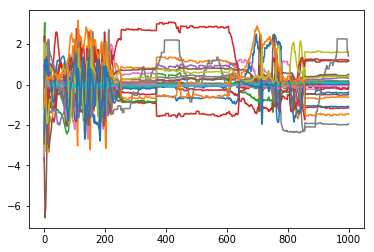

In [9]:
import matplotlib.pyplot as plt
plt.plot(some_runs[20].obs_l[0])
plt.show()

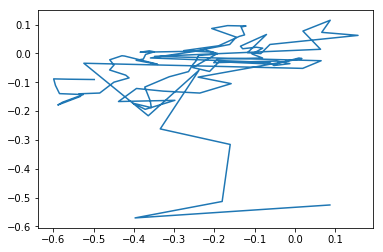

In [10]:
obs_l = some_runs[41].obs_l[0]
plt.plot(obs_l[:100, 0], obs_l[:100, 10])
plt.show()

In [11]:
network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 36)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 256, 36)      0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 128, 64)      16192       input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 256, 36)      0           input_2[0][0]                    
                                                                 input_1[0][0]                    
__________

In [90]:
from noise import pnoise1
def makeNoise(l):
    start = np.random.random() * 10000
    out = []
    for _ in range(l):
        a = pnoise1(_ / 40 + start, 5)
        out.append(a)
    return np.array(out)
def mask():
    m1 = makeNoise(256) > 0
    m1 = m1.reshape (256, 1)
    m1 = np.repeat(m1,3, 1)
    
    m2 = makeNoise(256) > 0
    m2 = m2.reshape (256, 1)
    m2 = np.repeat(m2, 32, 1)
    
    m3 = makeNoise(256) > 0
    m3 = m3.reshape (256, 1)
    #m3 = np.repeat(m, 36, 1)
    #m[:, :3] = 1
    return np.concatenate([m1, m2, m3], -1)

def mask():
    m = makeNoise(256) > 0
    m = m.reshape (256, 1)
    m = np.repeat(m, 36, 1)
    m[:, :3] = 1
    return m

In [13]:
full_data = [
    np.concatenate([
        r.action_l[:r.obs_l[0].shape[0]], 
        r.obs_l[0], 
        np.expand_dims(r.reward_l, 1)
    ], axis=1) 
    for r in some_runs 
    if len(r.reward_l) > 256
]

In [83]:
data_starts = [np.random.randint(0, len(ar) - 256) for ar in full_data]
data_cropped = np.array([f[start:256 + start] for f, start in zip(full_data, data_starts)])
masks = np.array([mask() for _ in range(len(data_cropped))])

In [92]:
network.compile(loss=keras.losses.mse, optimizer=keras.optimizers.adam())

In [106]:
for _ in range(80):
    data_starts = [np.random.randint(0, len(ar) - 256) for ar in full_data]
    data_cropped = np.array([f[start:256 + start] for f, start in zip(full_data, data_starts)])
    masks = np.array([mask() for _ in range(len(data_cropped))])
    network.fit([data_cropped[:-200], masks[:-200]], data_cropped[:-200], validation_data=
               ([data_cropped[-200:], masks[-200:]], data_cropped[-200:]))

Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 811us/step - loss: 0.0246 - val_loss: 0.0221
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 824us/step - loss: 0.0244 - val_loss: 0.0224
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 814us/step - loss: 0.0244 - val_loss: 0.0209
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 816us/step - loss: 0.0234 - val_loss: 0.0202
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 819us/step - loss: 0.0237 - val_loss: 0.0198
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 818us/step - loss: 0.0229 - val_loss: 0.0194
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] 

9796/9796 [==============================] - 8s 804us/step - loss: 0.0179 - val_loss: 0.0155
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 804us/step - loss: 0.0177 - val_loss: 0.0160
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 804us/step - loss: 0.0176 - val_loss: 0.0164
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 806us/step - loss: 0.0176 - val_loss: 0.0184
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 804us/step - loss: 0.0173 - val_loss: 0.0165
Train on 9796 samples, validate on 200 samples
Epoch 1/1
9796/9796 [==============================] - 8s 808us/step - loss: 0.0173 - val_loss: 0.0165
Train on 9796 samples, validate on 200 samples
Epoch 1/1
3936/9796 [===========>..................] - ETA: 4s - loss: 0.0185

KeyboardInterrupt: 

In [19]:
data_out = network.predict([data_cropped, masks])

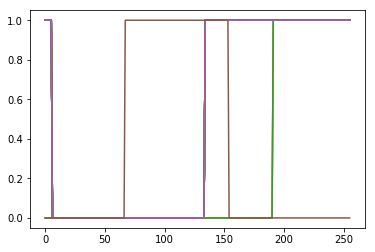

In [86]:
import cv2
def watch(fulld):
    
    decoded = vae.decoder.predict(fulld[:, 3:35])
    for im in decoded:
        cv2.imshow("hi", im)
        if cv2.waitKey(10) != -1:
            break
plt.plot(masks[-15])
plt.show()
watch(data_cropped[-15])


In [21]:
watch(data_out[-15])

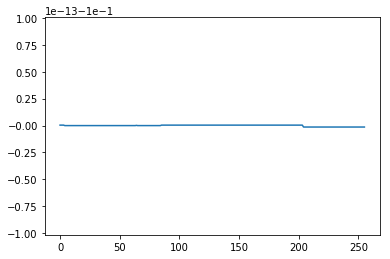

In [87]:
plt.plot(data_cropped[-15,:,  -1])

In [26]:
def control_mask(len_init):
    out = np.concatenate([np.ones(len_init), np.zeros(256 - len_init)])
    out = out.reshape(1, 256, 1)
    out = np.repeat(out, 36, 2)
    out[:,:, :3] = 1
    return out

In [27]:
def apply_action(full_data, len_init, action):
    out = full_data.copy()
    out[:, len_init:, :3] = np.array(action).reshape(-1, 1, 3)
    return out

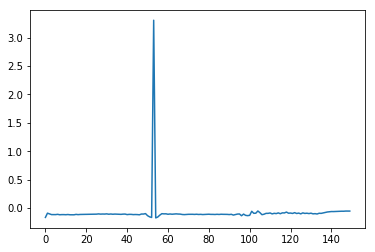

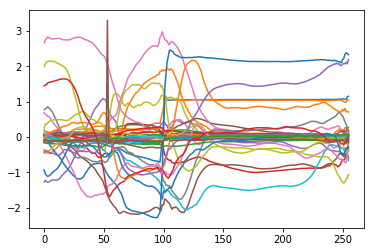

In [105]:

n = 10
control_out = network.predict([apply_action(data_cropped[-n:-n + 1], 100, [1, 1, 0]), control_mask(100)])
watch(control_out[0, :256])
plt.plot(control_out[0, 0:150, -1])
score = np.sum(control_out[0, 100:115, -1])
score
plt.show()
plt.plot(control_out[0])

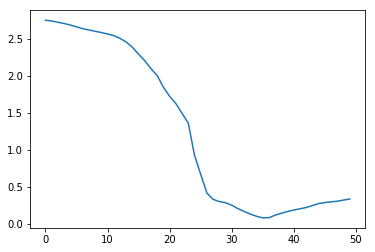

In [116]:
def score(full_data, len_init, action):
    
    network_out = network.predict([
        apply_action(full_data, len_init, action),
        np.repeat(control_mask(len_init), len(np.reshape(action, (-1, 1, 3))), 0)
    ])
    score = np.sum(network_out[:, len_init:len_init + 19, -1], axis=1)
    return score
plt.plot([score(data_cropped[-n:-n + 1], 100, [ctrl, 1, 0]) for ctrl in np.linspace(-1, 1, 50)])
plt.show()


In [31]:
import noise
import gym
import matplotlib.pyplot as plt
import numpy as np




env = gym.make("CarRacing-v0")
from pyglet import gl
import cProfile
_ = env.reset()


Track generation: 1153..1446 -> 293-tiles track


In [32]:
env.action_space.sample()

array([0.09762701, 0.71518934, 0.60276335], dtype=float32)

In [33]:
env.action_space.low

array([-1.,  0.,  0.], dtype=float32)

In [95]:
def choose_action(state, len_init):
    candidate_actions = [env.action_space.sample() for _ in range(90)]
    scores = score(
        np.repeat(np.expand_dims(state, 0),len(candidate_actions), 0), 
        len_init, candidate_actions
    ) 
    
    return candidate_actions[np.argmax(scores)]

In [44]:
choose_action(data_cropped[-n], 100)

array([0.6340931, 0.9056904, 0.0139875], dtype=float32)

In [118]:
def modelRun():
    _ = env.reset()
    done = False
    run = Run()
    i = 0
    
    
    while not done:
        if i == 0:
            full_state = np.zeros((256, 36))
        elif i < 128:
            full_state = np.concatenate([
                run.action_l, 
                vae.encoder.predict(np.array(run.obs_l) / 255.)[0], 
                np.expand_dims(run.reward_l, 1)
            ], axis=1) 
            full_state = np.concatenate([
                full_state,
                np.zeros((256 - i, 36))
            ])
        else: 
            full_state = np.concatenate([
                run.action_l[-128:], 
                vae.encoder.predict(np.array(run.obs_l[-128:]) / 255.)[0], 
                np.expand_dims(run.reward_l[-128:], 1)
            ], axis=1) 
            full_state = np.concatenate([
                full_state,
                np.zeros((128, 36))
            ])
        action = choose_action(full_state, np.min([i, 128]))
        i += 1
        obs, reward, done, _ = env.step(action)
        run.action_l.append(action)
        
        run.obs_l.append(obs)
        run.reward_l.append(reward)
        #if (len(run.reward_l) % 280 == 0):
        env.render()
    if encoded:
        run.obs_l = vae.encoder.predict(np.array(run.obs_l) / 255.)
    return run

run = modelRun()

Track generation: 1079..1353 -> 274-tiles track


NameError: name 'encoded' is not defined